# WGAN-GP DNA Generation

## Imports

In [1]:
import os
import time
import json
import random

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim, autograd

from datasets.ChrDataset import ChrDataset
from models.Discriminator import Discriminator
from models.Generator import Generator
from models.WGANGP import WGANGP
from trainers.wgan_gp_trainer import WGANGPTrainer
from evaluators.wgan_gp_evaluator import WGANGPEvaluator
from utils.sequence_utils import *
from utils.tensor_utils import *

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Data Preprocessing

In [2]:
# Set the random seeds for reproducability
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

np.random.seed(SEED)

random.seed(SEED)

In [ ]:
# Run only if gpu is available
torch.cuda.set_device(0)

### Dataset Generating Functions

In [3]:
# TODO - expand this to generate by kmer, which will take an array of size 4 ** k.
def generate_dataset_by_one_mer(name, size=5000000, probs=[0.25,0.25,0.25,0.25]):
    """Generates a dna dataset, with given name and size.
    
        Args:
            name (string): name for given dataset, will be used to name the folder conatinign it.
            size (int): number of bases to be included in the dataset. For example size 6 may result in aacgtg
            probs (list): probabilty for every nucleutide base to be chosen.
    """
    folder_path = f'./data/{name}'
    if os.path.exists(folder_path):
        print("Dataset already exists")
        return

    if (np.sum(probs) != 1.0):
        print("probs don't sum to 1")
        return
    
    os.makedirs(folder_path)
    os.makedirs(os.path.join(folder_path,"raw"))
    os.makedirs(os.path.join(folder_path,"processed"))
        

    # Our dataset functions assume .fa files start with meaningless line, such as the case with hg files.
    raw_path = f'./data/{name}/raw/{name}.fa'
    f = open(raw_path, "a")
    f.write("\n")
    
    # Default in python 3 is unicdoe string, we don't want this here.
    full_sequence = np.random.choice(['a','c','g','t'],size,p=probs).astype('S')
    full_sequence.tofile(f)
    
    # Write the probabilities that have generated this dataset
    data_file = open(os.path.join(folder_path,"meta.txt"),"w")
    data_file.write(json.dumps(size) + "\n" + json.dumps(probs))
    
    data_file.close()
    f.close()

In [6]:
generate_dataset_by_one_mer("gen", size=10000,probs=[0.2,0.2,0.3,0.3])

In [8]:
def get_data(dataset):
    """ Function to load both the train and test datasets of Chromosome1.
    Returns a tuple of both datasets.
    """
    # TODO - Change this to be normal
    out_dir = './data/' + dataset
    train_data = ChrDataset(root_folder=out_dir, raw_file=dataset + '.fa', train=True, sequence_size=50)
    test_data = ChrDataset(root_folder=out_dir, raw_file=dataset + '.fa', train=False, sequence_size=50)
    return train_data, test_data

try:
   del train_data
   del test_data
   print('Clear previously loaded data.')
except:
   pass

train_data, test_data = get_data('gen')

In [9]:
# Visualize dimensions and number of instatnces
print("Number of train data sequences:", len(train_data))
print("Shape first train sequence one hot:",train_data[0].shape)

print("Number of test data before split into test-valid sequences:", len(test_data))
print("Shape fisrt test sequence one hot:",test_data[0].shape)


Number of train data sequences: 160
Shape first train sequence one hot: torch.Size([50, 4])
Number of test data before split into test-valid sequences: 40
Shape fisrt test sequence one hot: torch.Size([50, 4])


In [10]:
# Split test data to validation and test set. Note that this should be deterministic with seed = 1337
test_set_size = len(test_data)
test_length = int(0.5 * test_set_size)
validation_len = test_set_size - test_length

# Torch's seed comes into play in this line!
test_data, validation_data = torch.utils.data.dataset.random_split(test_data, lengths=[test_length, validation_len])

In [11]:
print("Number of test data sequences:", len(test_data))
print("Number of validation data sequences:", len(validation_data))

Number of test data sequences: 20
Number of validation data sequences: 20


In [12]:
from torch.utils.data import sampler, DataLoader

# We now make a data loader for the validtaion set, that submsamples from it. We don't need a whole
# lof of validation here.
num_validation = len(validation_data)
num_batches = 100
batch_size = 128
# Define a subsampler for the last 100 batches of validation data set.
sampler = sampler.SubsetRandomSampler(range(num_validation - batch_size * num_batches, num_validation))

In [13]:
validation_data_loader = DataLoader(validation_data,
                    batch_size=batch_size,
                    sampler=sampler)

In [14]:
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=128,
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=4)

In [15]:
print("number of training batches ", len(train_data_loader))
print("number of validation batches ", len(validation_data_loader))

number of training batches  1
number of validation batches  100


## Training

# Train with x data 4 epoch

In [253]:
# Both generator and discriminator could be any nn, as long as generator exposes latent_dim variable.
discriminator = Discriminator(conv_dim=100, seq_length=50)
generator = Generator(latent_dim=100, conv_dim=100, seq_length=50)

# Note that turninig our WGANGP object to cuda turns both discriminator and generator to .cuda as they are child models.
wgan_gp = WGANGP(discriminator=discriminator, generator=generator).cuda()

trainer = WGANGPTrainer(wgan_gp,
                        train_data_loader=train_data_loader,
                        validation_data_loader=validation_data_loader,
                        should_log_tbx=False,
                        num_epochs=4,)

trainer.train()

# Train with 2x data 2 epoch

In [263]:
# Both generator and discriminator could be any nn, as long as generator exposes latent_dim variable.
discriminator = Discriminator(conv_dim=100, seq_length=50)
generator = Generator(latent_dim=100, conv_dim=100, seq_length=50)

# Note that turninig our WGANGP object to cuda turns both discriminator and generator to .cuda as they are child models.
wgan_gp = WGANGP(discriminator=discriminator, generator=generator).cuda()

trainer = WGANGPTrainer(wgan_gp,
                        train_data_loader=train_data_loader,
                        validation_data_loader=validation_data_loader,
                        should_log_tbx=False,
                        num_epochs=2,)

trainer.train()

# Train with 4x data 1 epoch

In [274]:
# Both generator and discriminator could be any nn, as long as generator exposes latent_dim variable.
discriminator = Discriminator(conv_dim=100, seq_length=50)
generator = Generator(latent_dim=100, conv_dim=100, seq_length=50)

# Note that turninig our WGANGP object to cuda turns both discriminator and generator to .cuda as they are child models.
wgan_gp = WGANGP(discriminator=discriminator, generator=generator).cuda()

trainer = WGANGPTrainer(wgan_gp,
                        train_data_loader=train_data_loader,
                        validation_data_loader=validation_data_loader,
                        should_log_tbx=False,
                        num_epochs=1,)

trainer.train()

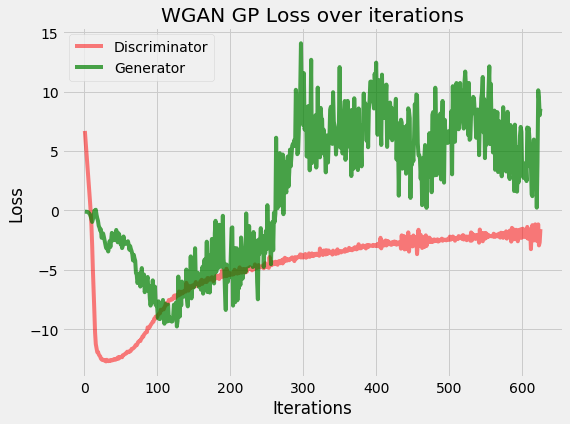

In [126]:
trainer.plot_loss()

In [128]:
gan = wgan_gp
gan.eval()

WGANGP(
  (discriminator): Discriminator(
    (block): Sequential(
      (0): ResBlock(
        (res_block): Sequential(
          (0): ReLU()
          (1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
          (2): ReLU()
          (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
        )
      )
      (1): ResBlock(
        (res_block): Sequential(
          (0): ReLU()
          (1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
          (2): ReLU()
          (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
        )
      )
      (2): ResBlock(
        (res_block): Sequential(
          (0): ReLU()
          (1): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
          (2): ReLU()
          (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
        )
      )
      (3): ResBlock(
        (res_block): Sequential(
          (0): ReLU()
          (1): Conv1d(100, 100, kernel_size=(5,

In [129]:
# Sample batch of 10 vectors from latent space
batch_of_latent = to_cuda(torch.randn(10, 100))

# Generate Sequences
generated_sequence = gan.generator(batch_of_latent).detach()

for i in range(10):
    print("Generated Sequence %d: %s" % (i+1, one_hot_to_seq(generated_sequence[i].max(dim=1)[1])))

Generated Sequence 1: tacgcaaacgttccaacacccctaggtcagccaccacagggtagcaacac
Generated Sequence 2: atctatcatcccgtaactgtcctattctcagcccagttaaatccccctgc
Generated Sequence 3: acaacagtttccactgcagctctcagtaccagaacaatcggattggctct
Generated Sequence 4: accaaggcacgccctaccctcaacccatctcccaacgattcccttacgca
Generated Sequence 5: cacacactgcggcagtcactccgacctccccgccggatgcgcagtgctcc
Generated Sequence 6: gacgctcaaccgcgagcctcgctttccgaacacccaaaggttagcctgcg
Generated Sequence 7: agacacaactcccttgcgctccagctcagtaataatacccgtccatgcat
Generated Sequence 8: tgccgccagaaatcccgccggaagctggctccgcagccctacgcccgatc
Generated Sequence 9: acccaactactcccgagtcgccgctccgctctgcgtaagaagtatgcctc
Generated Sequence 10: cggacatcgcgtcacatgcccgttagccgcctgctctggtcctaccggac


## Analyze Kmer proportions

In [275]:
%matplotlib inline
from IPython.core.pylabtools import figsize

plt.style.use('seaborn-deep')

def draw_histogram_for_k(k):
    figsize(12, 10)

    sorted_keys = sorted(trainer.evaluator.real_kmer_model[k]._kmer_counts.keys())
    generated = [trainer.evaluator.kmer_proportions_history[k][-1][key] for key in sorted_keys]
    real = [trainer.evaluator.real_kmer_model[k]._kmer_counts[key] for key in sorted_keys]

    x = np.array(real)
    x = x / np.sum(x)

    y = np.array(generated)
    y = y / np.sum(y)

    ind = np.arange(4**k)  # the x locations for the groups
    width = 0.35       # the width of the bars

    ax = plt.subplot(2, 2, k + 1)
    real = ax.bar(ind, x, width, color='magenta', alpha=0.5)
    generated = ax.bar(ind + width, y, width, color='b', alpha=0.5)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Frequency')
    ax.set_title('Real and Generated')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(sorted_keys)

    ax.legend((real[0], generated[0]), ('real', 'generated'))
    plt.tight_layout()
    plt.show()

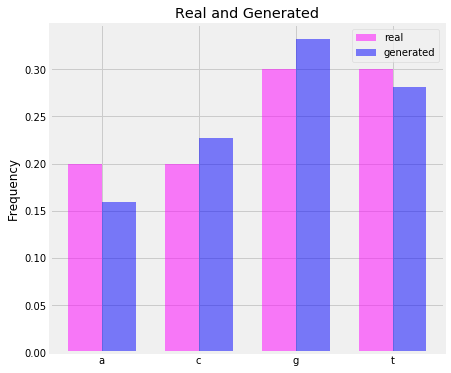

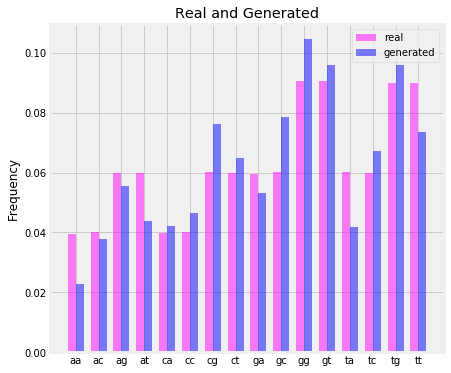

In [276]:
for k in [1,2]:
    draw_histogram_for_k(k)